# Analyze neutralization data
This Python Jupyter notebook analyzes the neutralization data.

Import Python modules.
We use [neutcurve](https://jbloomlab.github.io/neutcurve/) to plot the neutralization curves:

In [1]:
import itertools
import math
import re
import warnings
import xml.etree.ElementTree as ElementTree

from IPython.display import display, HTML, SVG

import matplotlib.pyplot as plt

import neutcurve
from neutcurve.colorschemes import CBPALETTE
from neutcurve.colorschemes import CBMARKERS

import pandas as pd

from plotnine import *

import svgutils.compose

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.3


Specify input / output files:

In [2]:
# input files
fracinfect_file = 'results/fracinfect.csv'
serum_info_file = 'serum_info.csv'

# output files
all_replicate_curves = 'results/all_neut_replicates.pdf'
all_neut_by_sera_curves = 'results/all_neut_by_sera.pdf'
all_fit_params = 'results/all_fit_params.csv'
all_neut_titers = 'results/all_neut_titers.csv'

Read in the neutralization data, dropping sera labeled as "Nothing":

In [3]:
print(f"Reading neutralization data from {fracinfect_file}")
fracinfect = pd.read_csv(fracinfect_file)

# Input data restarts replicate numbers for each new date. Instead label replicates as:
#  - replicate_on_date: number of the replicate on that specific date
#  - replicate_with_date: number of replicate on that date suffixed by date
#  - replicate_all_dates: number replicates sequentially across all dates
fracinfect = (
    fracinfect
    .query('serum != "Nothing"')
    .assign(replicate_with_date=lambda x: x['replicate'].astype(str) +
                                          ' (' + x['date'] + ')')
    .rename(columns={'replicate': 'replicate_on_date'})
    )
fracinfect = (
    fracinfect
    .merge(fracinfect
           .sort_values('date')
           [['serum', 'virus', 'replicate_with_date']]
           .drop_duplicates()
           .assign(replicate_all_dates=lambda x: x.groupby(['serum', 'virus'])
                                                  ['replicate_with_date']
                                                  .transform('cumcount') + 1
                   ),
            how='left', on=['serum', 'virus', 'replicate_with_date'], validate='many_to_one',
            )
    )

# make sure unique reading for each virus / serum / replicate / date
assert len(fracinfect) == len(fracinfect.groupby(['serum',
                                                  'virus',
                                                  'replicate_all_dates',
                                                  'concentration',
                                                  ]))

# order the viruses
virus_order = ['229E-1984', '229E-1992', '229E-2001', '229E-2008', '229E-2016',
               '229E-1992-RBD', '229E-2001-RBD', '229E-2008-RBD', '229E-2016-RBD']
extra_viruses = set(fracinfect['virus']) - set(virus_order)
if extra_viruses:
    raise ValueError(f"extra viruses not in `virus_order`:\n{extra_viruses}")
fracinfect = (
    fracinfect
    .assign(virus=lambda x: pd.Categorical(x['virus'], virus_order, ordered=True))
    .sort_values(['serum', 'virus', 'date'])
    )

# show first few lines of data frame
display(HTML(fracinfect.head().to_html(index=False)))

Reading neutralization data from results/fracinfect.csv


serum,virus,replicate_on_date,concentration,fraction infectivity,date,replicate_with_date,replicate_all_dates
AUSAB-01,229E-2016,1,0.100000,0.1709,2020-11-27,1 (2020-11-27),1
AUSAB-01,229E-2016,1,0.033330,0.5763,2020-11-27,1 (2020-11-27),1
AUSAB-01,229E-2016,1,0.011110,0.9789,2020-11-27,1 (2020-11-27),1
AUSAB-01,229E-2016,1,0.003704,0.8578,2020-11-27,1 (2020-11-27),1
AUSAB-01,229E-2016,1,0.001235,1.2120,2020-11-27,1 (2020-11-27),1


Get information on sera:

In [4]:
serum_info = (
    pd.read_csv(serum_info_file)
    .assign(collection_date=lambda x: pd.to_datetime(x['collection_date']),
            collection_year=lambda x: x['collection_date'].dt.year +
                                      (x['collection_date'].dt.dayofyear - 1) / 365,
            collection_year_round=lambda x: x['collection_year']
                                            .map(lambda y: str(int(round(y)))
                                                           if pd.notnull(y)
                                                           else 'unknown'),
            serum_year=lambda x: x.apply(lambda r: f"{r['serum']} ({r['collection_year_round']})"
                                                   if r['category'] == 'human' else
                                                   f"{r['serum']} ({r['category']})",
                                         axis=1)
            )
    .sort_values('collection_date')
    )
    
assert len(serum_info) == serum_info['serum'].nunique()
print(f"Read information for {len(serum_info)} sera")

sera_lacking_info = set(fracinfect['serum']) - set(serum_info['serum'])
if sera_lacking_info:
    raise ValueError(f"lacking information for these sera: {sera_lacking_info}")

# show first few lines of sera information data frame:
display(HTML(serum_info.head().to_html(index=False)))

Read information for 78 sera


serum,collection_date,age,category,notes,collection_year,collection_year_round,serum_year
SD85_1,1985-01-03,27,human,sera,1985.005479,1985,SD85_1 (1985)
SD85_2,1985-01-08,20,human,sera,1985.019178,1985,SD85_2 (1985)
SD85_3,1985-04-10,26,human,sera,1985.271233,1985,SD85_3 (1985)
SD85_4,1985-04-11,23,human,sera,1985.273973,1985,SD85_4 (1985)
SD85_5,1985-04-18,23,human,sera,1985.293151,1985,SD85_5 (1985)


Use [neutcurve](https://jbloomlab.github.io/neutcurve/) to fit neutralization curves to all of the data:

In [5]:
fits = neutcurve.curvefits.CurveFits(
            data=fracinfect,
            replicate_col='replicate_all_dates',
            fixbottom=0,
            fixtop=1,
            )

Plot all curves for all replicates of all virus / serum combinations:

Saving plot to results/all_neut_replicates.pdf



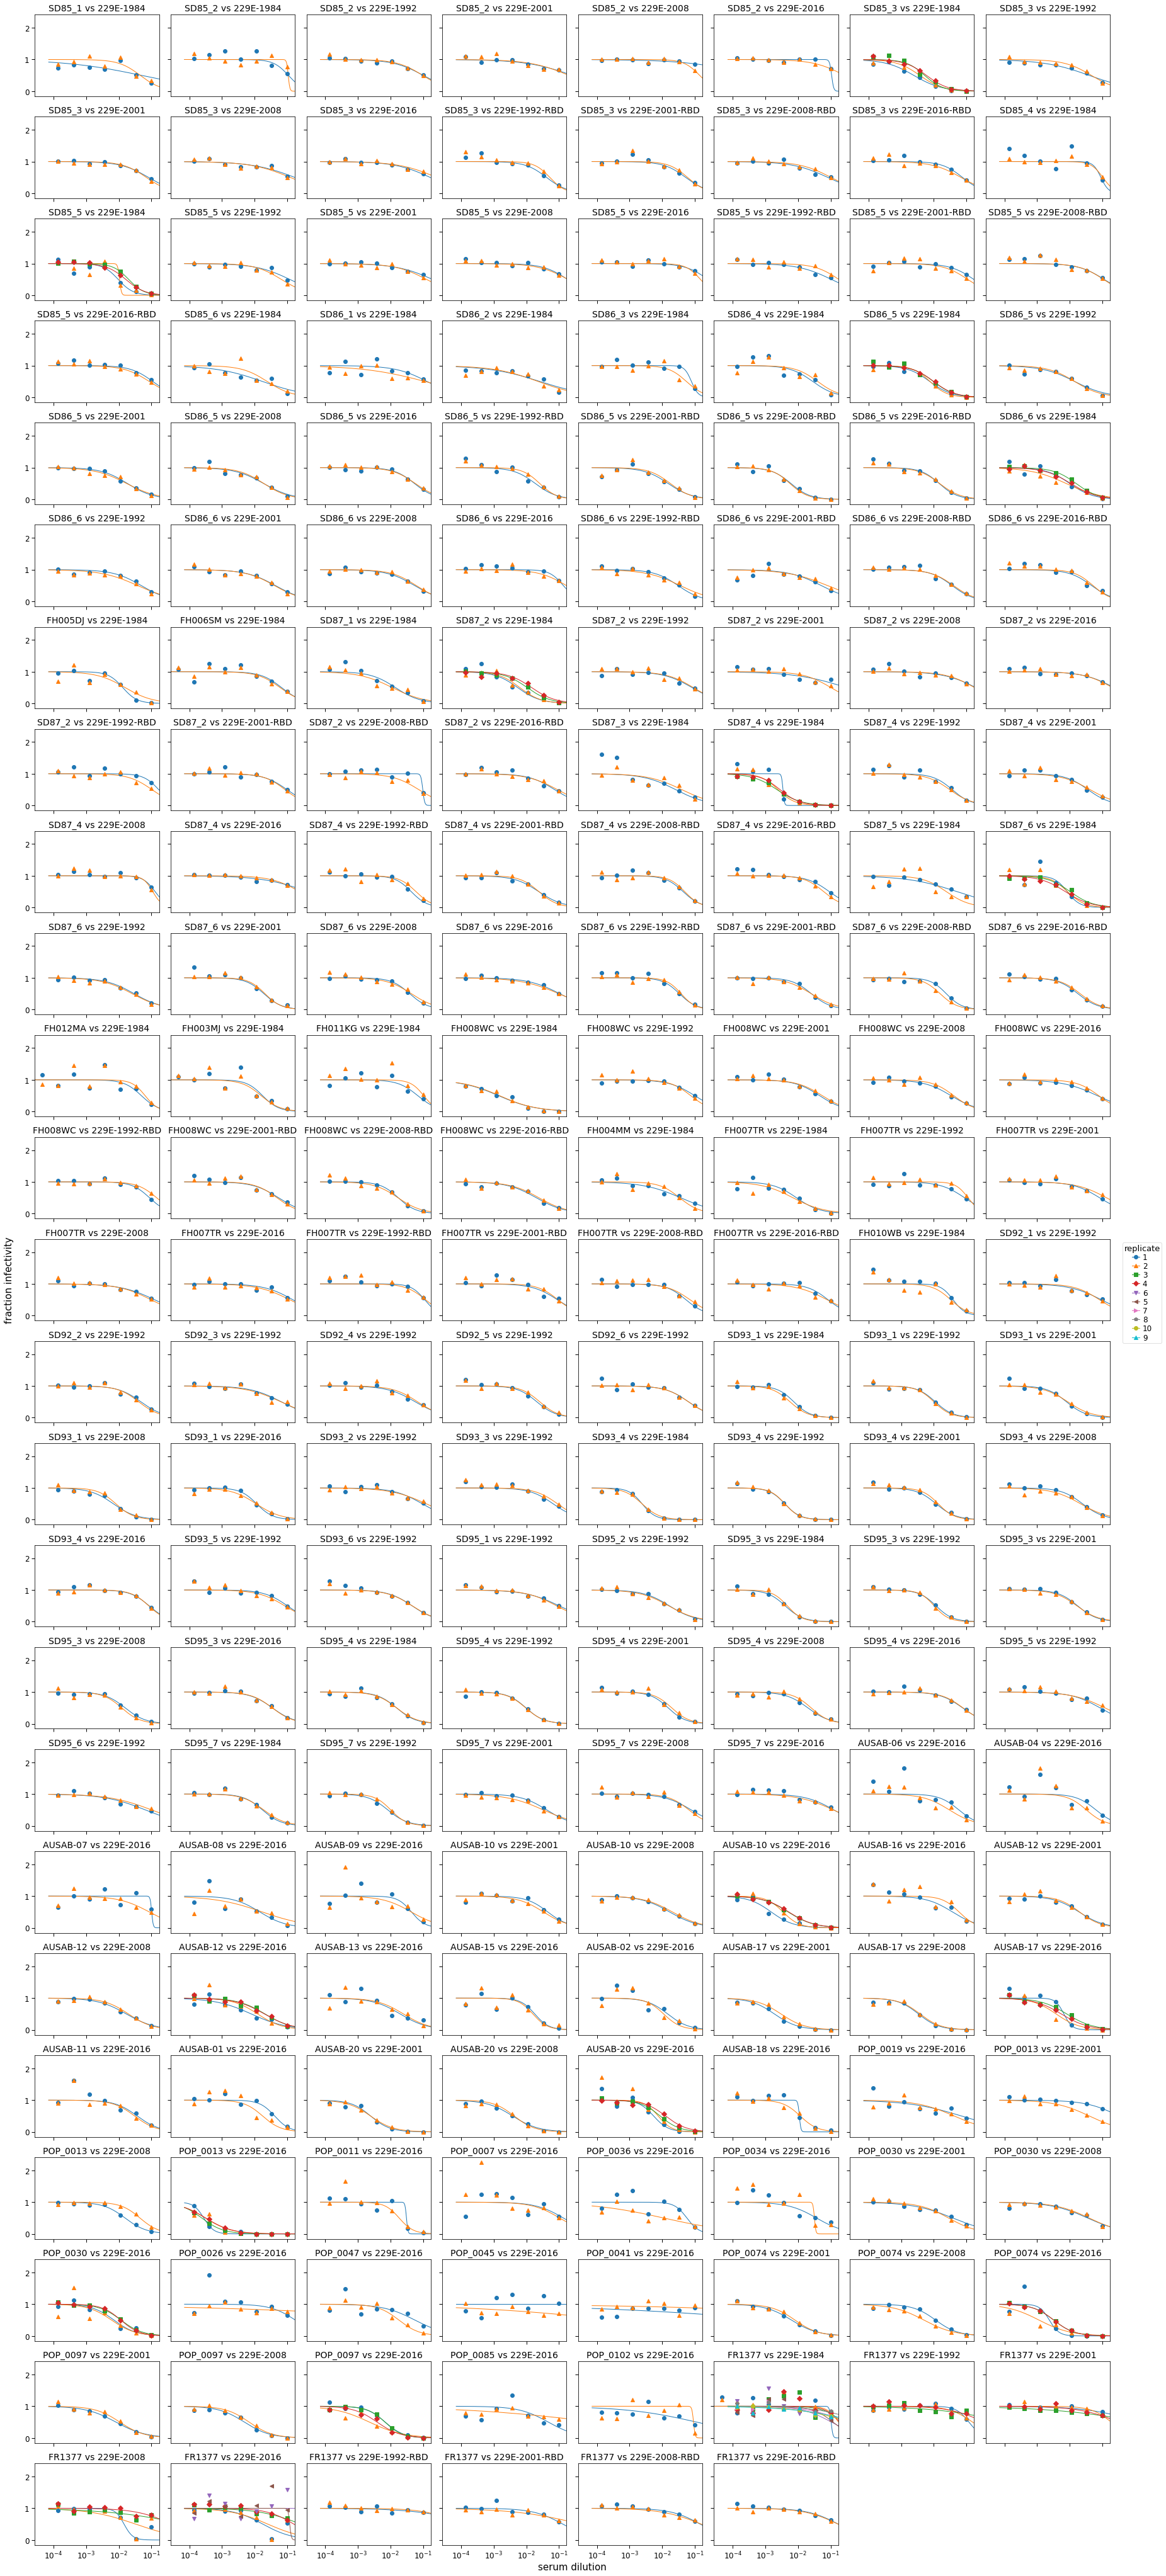

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # ignore fitting warnings
    fig, _ = fits.plotReplicates(ncol=8,
                                 legendtitle='replicate',
                                 xlabel='serum dilution',
                                 sera=serum_info['serum'],
                                 viruses=fracinfect['virus'].sort_values().unique(),
                                 colors=plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2,
                                 markers=['o', '^', 's', 'D', 'v', '<', '>', 'p'] * 2,
                                 )
    
print(f"Saving plot to {all_replicate_curves}\n")
fig.savefig(all_replicate_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Make a plot showing all viruses against each sera:

/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/neutcurve/hillcurve.py:689: RuntimeWarning: invalid value encountered in power


Saving plot to results/all_neut_by_sera.pdf



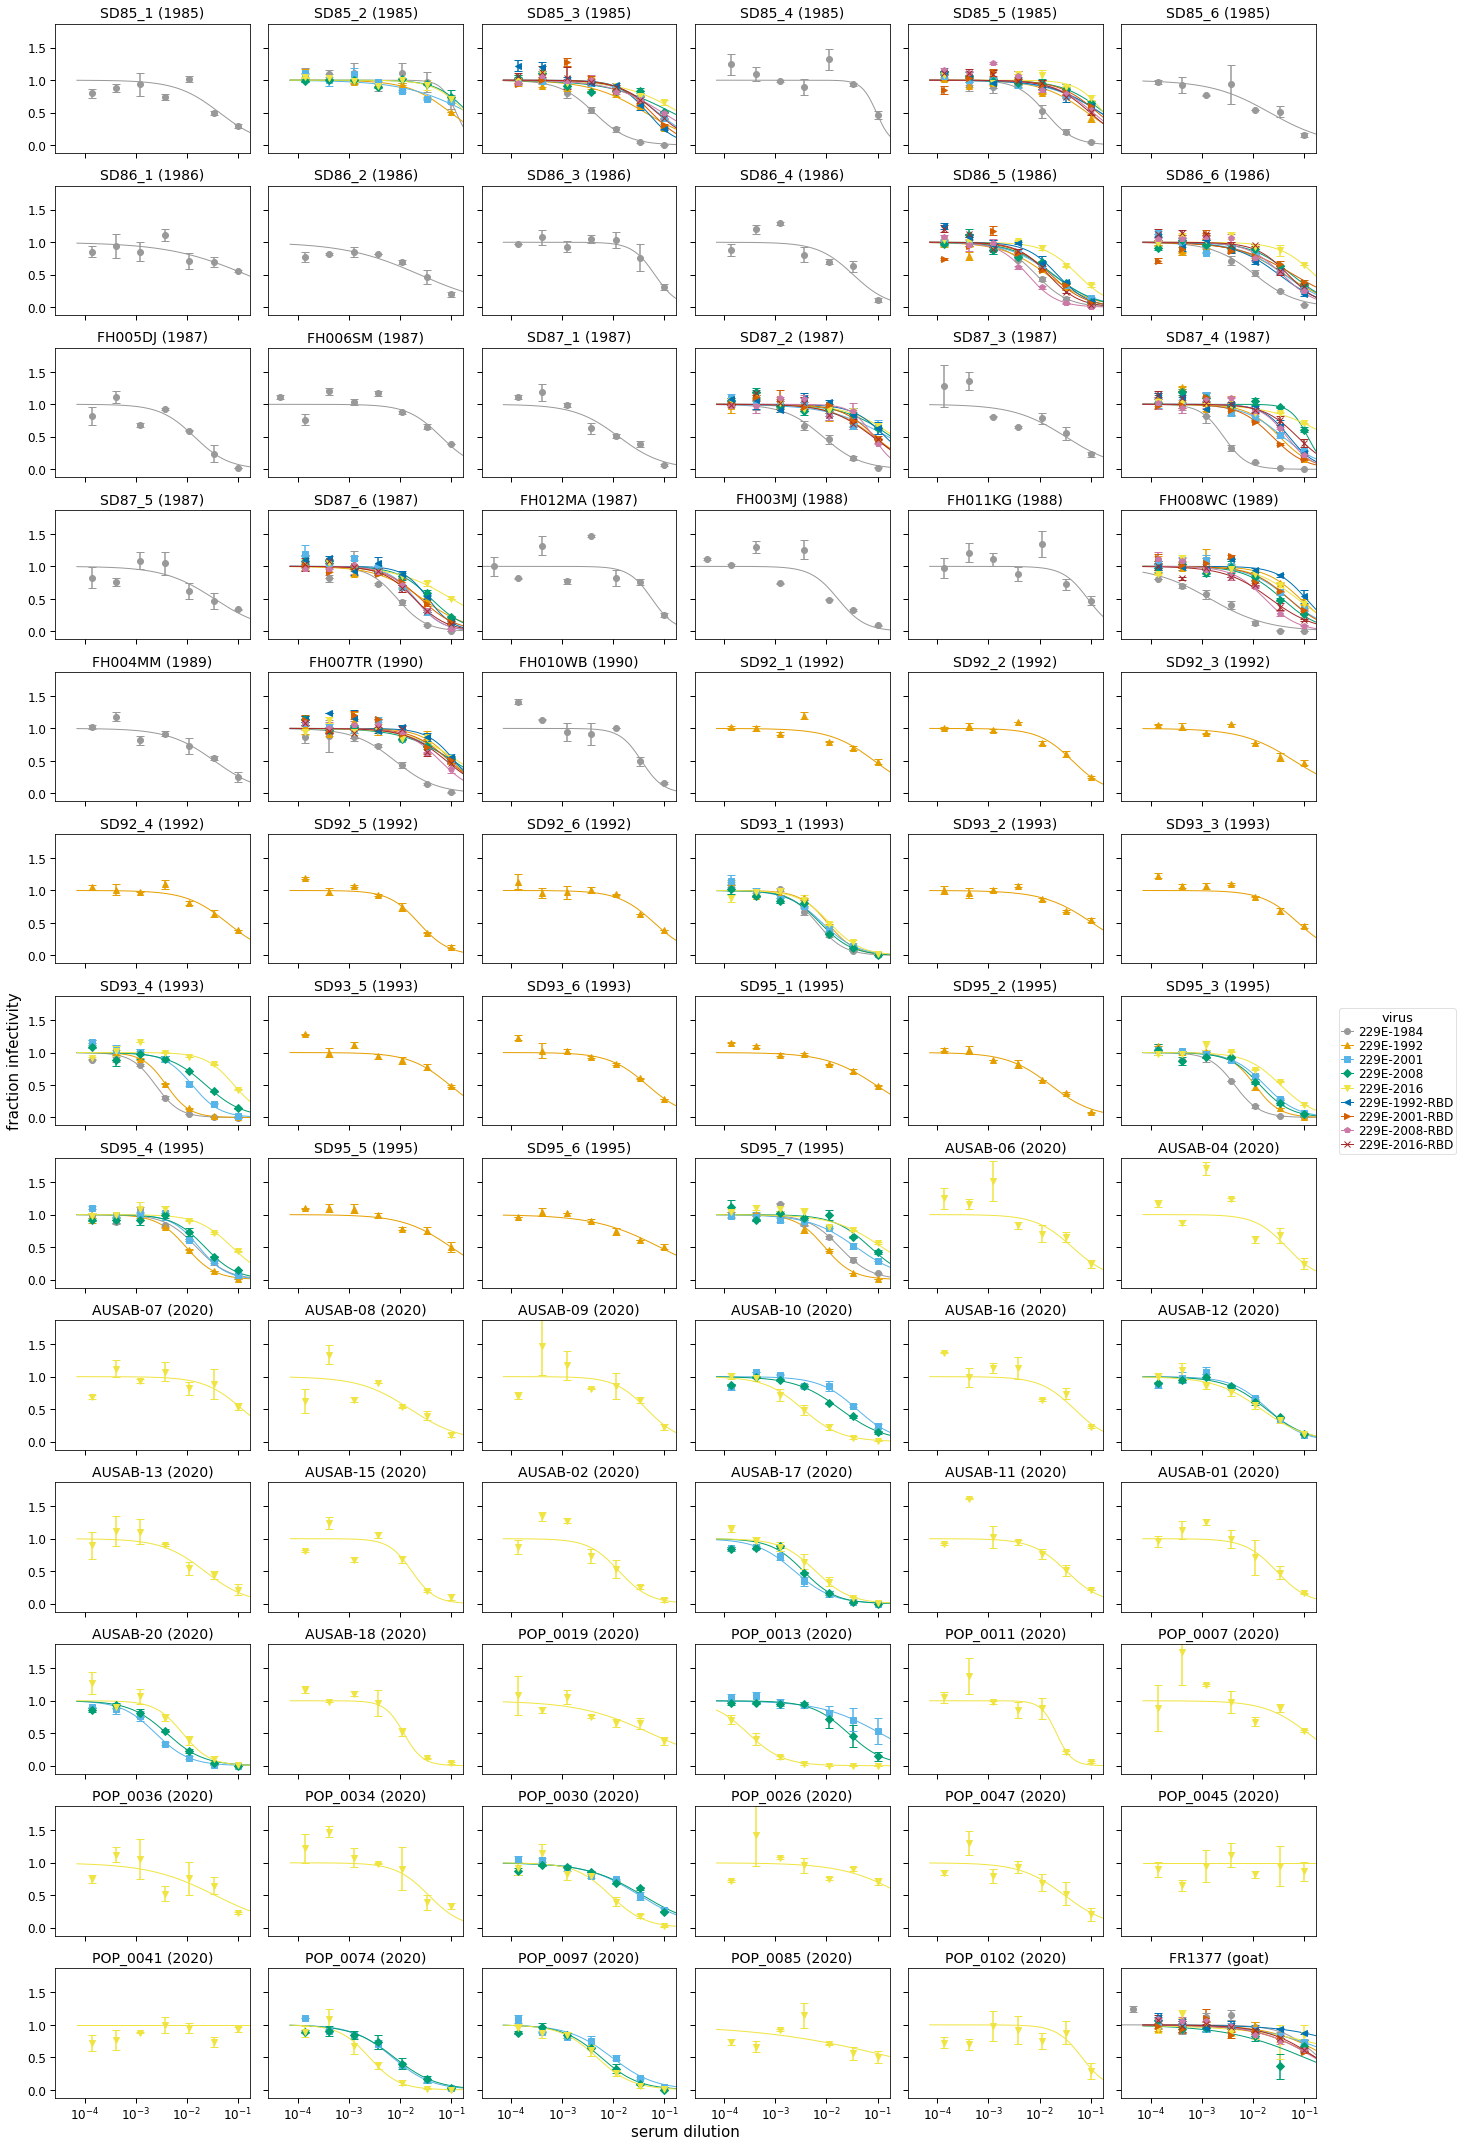

In [7]:
fig, _ = fits.plotSera(xlabel='serum dilution',
                       ncol=6,
                       legendtitle='virus',
                       viruses=fracinfect['virus'].sort_values().unique(),
                       sera=serum_info['serum'],
                       titles=serum_info['serum_year'],
                       max_viruses_per_subplot=9,
                       colors=[*CBPALETTE, 'brown'],
                       markers=[*CBMARKERS, 'x'],
                       )

print(f"Saving plot to {all_neut_by_sera_curves}\n")
fig.savefig(all_neut_by_sera_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Write all of the fit parameters to a file:

In [8]:
print(f"Writing all fit parameters to {all_fit_params}; first few lines also printed below:")

display(HTML(fits.fitParams().head().to_html(index=False)))

fits.fitParams().to_csv(all_fit_params, index=False)

Writing all fit parameters to results/all_fit_params.csv; first few lines also printed below:


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
AUSAB-01,229E-2016,average,2,0.029006,interpolated,0.029,0.029006,1.416834,1,0
AUSAB-02,229E-2016,average,2,0.013032,interpolated,0.013,0.013032,1.449511,1,0
AUSAB-04,229E-2016,average,2,0.045668,interpolated,0.0457,0.045668,1.418362,1,0
AUSAB-06,229E-2016,average,2,0.043231,interpolated,0.0432,0.043231,1.212101,1,0
AUSAB-07,229E-2016,average,2,0.100000,lower,>0.1,0.121031,1.162661,1,0


Get neutralization titers, and merge them with information on the sera:

In [9]:
neut_titers = (
    fits.fitParams()
    .assign(neut_titer=lambda x: 1 / x['ic50'])
    .assign(is_upper_bound=lambda x: x['ic50_bound'].map({'lower': True,
                                                          'interpolated': False}))
    [['serum', 'virus', 'neut_titer', 'is_upper_bound']]
    .merge(serum_info[['serum', 'serum_year', 'collection_date', 'collection_year', 'age']],
           how='left', validate='many_to_one', on='serum')
    )

print(f"Writing neut titers to {all_neut_titers}; first few lines also printed below:")

display(HTML(neut_titers.head().to_html(index=False, float_format='%.1f')))

neut_titers.to_csv(all_neut_titers, index=False, float_format='%.1f')

Writing neut titers to results/all_neut_titers.csv; first few lines also printed below:


serum,virus,neut_titer,is_upper_bound,serum_year,collection_date,collection_year,age
AUSAB-01,229E-2016,34.5,False,AUSAB-01 (2020),2020-01-01,2020.0,61
AUSAB-02,229E-2016,76.7,False,AUSAB-02 (2020),2020-01-01,2020.0,73
AUSAB-04,229E-2016,21.9,False,AUSAB-04 (2020),2020-01-01,2020.0,44
AUSAB-06,229E-2016,23.1,False,AUSAB-06 (2020),2020-01-01,2020.0,50
AUSAB-07,229E-2016,10.0,True,AUSAB-07 (2020),2020-01-01,2020.0,44


Now for plotting annotate neut titers with information about:
 - virus year (for RBD chimeras this is year of the RBD)
 - the "closest" virus for each sera, which is the most recent (non-RBD chimera) virus isolated no later than the sera collection year
 - whether or not the virus is a RBD chimera

In [10]:
def get_virus_year(virus):
    m = re.fullmatch('229E\-(?P<year>\d{4})(?:\-RBD)?', virus)
    if not m:
        raise ValueError(f"cannot match virus year in {virus}")
    else:
        return int(m.group('year'))

annotated_neut_titers = (
    neut_titers
    .assign(virus_year=lambda x: x['virus'].map(get_virus_year),
            rbd_chimera=lambda x: x['virus'].map(lambda v: v[-4:] == '-RBD'))
    )

annotated_neut_titers = (
    annotated_neut_titers
    .merge(annotated_neut_titers.sort_values('virus_year')
                                .query('not rbd_chimera')
                                .query('collection_date.dt.year >= virus_year')
                                .groupby('serum', as_index=False)
                                .aggregate(closest_virus_year=pd.NamedAgg('virus_year', 'last'),
                                           closest_virus=pd.NamedAgg('virus', 'last')
                                           ),
           how='left', on='serum')
    .assign(closest_virus_year=lambda x: x['closest_virus_year'].astype('Int64'))
    )

Get lower bound for neutralization titers and make sure consistent across all samples:

In [11]:
titer_lower_bound = neut_titers.query('is_upper_bound')['neut_titer'].min()

print(f"The lower bound on measurable neutralization titers is {titer_lower_bound}")

assert (neut_titers.query('is_upper_bound')['neut_titer'] == titer_lower_bound).all()

The lower bound on measurable neutralization titers is 10.0


Set titer cutoff for samples that are analyzed against additional years:

In [12]:
titer_cutoff = 90

Plot distribution of titers for each sera against it's "closest" virus that is **not** a RBD chimera:


There are 27 sera with a most recent closest virus of 229E-1984.
These sera were collected between 1985 and 1990.
8 of the 27 sera have neut titers >90:


serum,virus,collection_date,age,neut_titer,is_upper_bound,sera_range
FH008WC,229E-1984,1989-02-06,unknown,684.4,False,1985-1990
SD87_4,229E-1984,1987-03-16,22,372.7,False,1985-1990
SD85_3,229E-1984,1985-04-10,26,236.1,False,1985-1990
FH007TR,229E-1984,1989-08-29,28,124.9,False,1985-1990
SD87_2,229E-1984,1987-01-22,24,116.8,False,1985-1990
SD86_5,229E-1984,1986-03-10,35,116.6,False,1985-1990
SD87_6,229E-1984,1987-04-30,29,112.5,False,1985-1990
SD86_6,229E-1984,1986-04-10,32,90.8,False,1985-1990



There are 19 sera with a most recent closest virus of 229E-1992.
These sera were collected between 1992 and 1995.
5 of the 19 sera have neut titers >90:


serum,virus,collection_date,age,neut_titer,is_upper_bound,sera_range
SD93_4,229E-1992,1993-03-15,20,252.5,False,1992-1995
SD95_7,229E-1992,1995-04-07,12,108.1,False,1992-1995
SD95_4,229E-1992,1995-02-28,unknown,103.5,False,1992-1995
SD93_1,229E-1992,1993-01-22,unknown,95.1,False,1992-1995
SD95_3,229E-1992,1995-02-21,unknown,91.6,False,1992-1995



There are 31 sera with a most recent closest virus of 229E-2016.
These sera were collected between 2020 and 2020.
7 of the 31 sera have neut titers >90:


serum,virus,collection_date,age,neut_titer,is_upper_bound,sera_range
POP_0013,229E-2016,2020-03-03,10 to <15 years,3432.6,False,2020-2020
POP_0074,229E-2016,2020-03-06,10 to <15 years,399.8,False,2020-2020
AUSAB-10,229E-2016,2020-01-01,73,289.3,False,2020-2020
POP_0097,229E-2016,2020-03-06,>15 years,209.3,False,2020-2020
AUSAB-17,229E-2016,2020-01-01,40,162.8,False,2020-2020
AUSAB-20,229E-2016,2020-01-01,47,121.2,False,2020-2020
POP_0030,229E-2016,2020-03-04,5 to <10 years,113.8,False,2020-2020



Distribution of titers of sera against its most recent closest virus:
Saving plot to results/all_neut_titers.svg


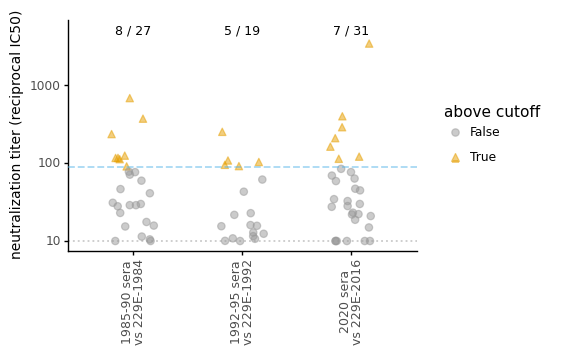

In [13]:
closest_virus_df = pd.DataFrame()
for closest_virus_year, df in annotated_neut_titers.groupby('closest_virus_year'):
    assert df['closest_virus'].nunique() == 1, df['closest_virus'].unique()
    closest_virus = df['closest_virus'].unique().tolist()[0]
    earliest_sera = df['collection_year'].round().sort_values().astype(int).tolist()[0]
    latest_sera = df['collection_year'].round().sort_values().astype(int).tolist()[-1]
    
    df_closest = (
        df
        .query('virus_year == @closest_virus_year')
        [['serum', 'virus', 'collection_date', 'age', 'neut_titer', 'is_upper_bound']]
        .sort_values('neut_titer', ascending=False)
        .assign(sera_range=f"{earliest_sera}-{latest_sera}",
                titer_to_closest_virus=lambda x: x['neut_titer'],
                closest_virus=closest_virus)
        )
    closest_virus_df = closest_virus_df.append(df_closest)
    
    above_cutoff = df_closest.query('neut_titer > @titer_cutoff')
    
    print(f"\nThere are {len(df_closest)} sera with a most recent closest virus of {closest_virus}.\n"
          f"These sera were collected between {earliest_sera} and {latest_sera}.\n"
          f"{len(above_cutoff)} of the {len(df_closest)} sera have neut titers >{titer_cutoff}:")
    display(HTML(above_cutoff
                 .drop(columns=['closest_virus', 'titer_to_closest_virus'])
                 .to_html(index=False, float_format='%.1f')
                 ))
    
print('\nDistribution of titers of sera against its most recent closest virus:')
def sera_range_to_xlabel(sera_range):
    start, end = sera_range.split('-')
    if start == end:
        return start
    else:
        return f"{start}-{end[-2:]}"
df_to_plot = (
    closest_virus_df
    .assign(above_cutoff=lambda x: x['neut_titer'] > titer_cutoff,
            xlabel=lambda x: x['sera_range'].map(sera_range_to_xlabel) +
                             ' sera\nvs ' + x['virus'],
            )
    .rename(columns={'above_cutoff': 'above cutoff'})
    )

p = (ggplot(df_to_plot) +
     aes('xlabel', 'neut_titer', color='above cutoff', shape='above cutoff') +
     geom_jitter(height=0, width=0.2, size=2.5,
                 alpha=0.5, random_state=1) +
     theme_classic() +
     theme(figure_size=(1.5 * closest_virus_df['virus'].nunique(), 3),
           axis_text_x=element_text(angle=90, size=9),
           axis_title_y=element_text(size=10)
           ) +
     scale_color_manual(values=CBPALETTE) +
     xlab('') +
     geom_hline(yintercept=titer_lower_bound, linetype='dotted', color=CBPALETTE[0], size=0.75, alpha=0.5) +
     geom_hline(yintercept=titer_cutoff, linetype='dashed', color=CBPALETTE[2], size=0.75, alpha=0.5) +
     geom_text(data=df_to_plot.groupby('xlabel', as_index=False)
                              .aggregate(ntot=pd.NamedAgg('serum', 'nunique'),
                                         n_above=pd.NamedAgg('above cutoff', 'sum')
                                         )
                              .assign(label=lambda x: x['n_above'].astype(str) + ' / ' + x['ntot'].astype(str)),
               mapping=aes(x='xlabel', label='label'),
               inherit_aes=False,
               y=1.05 * math.log10(df_to_plot['neut_titer'].max()),
               color='black',
               size=9,
               ) +
     scale_y_log10(name='neutralization titer (reciprocal IC50)', expand=(0.05, 0, 0.12, 0))
     )
_ = p.draw()
svg = 'results/all_neut_titers.svg'
print(f"Saving plot to {svg}")
p.save(svg, verbose=False)

Now plot neutralization titers as a function of virus isolation date for all viruses that were above the cutoff for their "closest" virus.
We do this both for the virus with full spikes and just the RBD chimeras.
Note that we "duplicate" the 1984 virus be both a full spike and RBD chimera for this plot, as the 1984 virus is really the chimera of the 1984 RBD in the 1984 virus.
We also shade by the date range the patient was alive.
The upper bound of this date range is just the collection date, but the lower bound must be computed for age.
When ages are just ranges, we take the middle of the range, and for plotting purposes we arbitrarily assume unknown age individuals are 40 (this doesn't have much effect as all of these individuals had sera collected quite close to earliest date plotted, so we are really just assuming they are not young children):


All sera including RBD chimera viruses:


/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/scales/scale_shape.py:79: PlotnineWarning: Using shapes for an ordinal variable is not advised.
/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/scales/scale_linetype.py:46: PlotnineWarning: Using linetype for an ordinal variable is not advised.


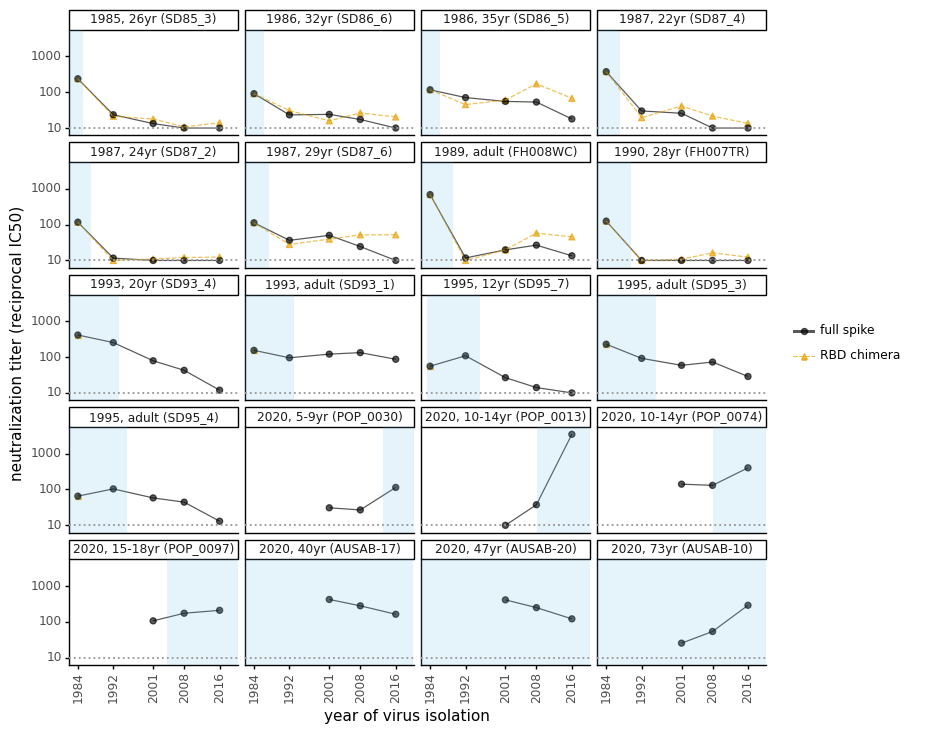


Sera with closest recent virus from 1984, full spike viruses only, saving to results/sera_1984.svg:


/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


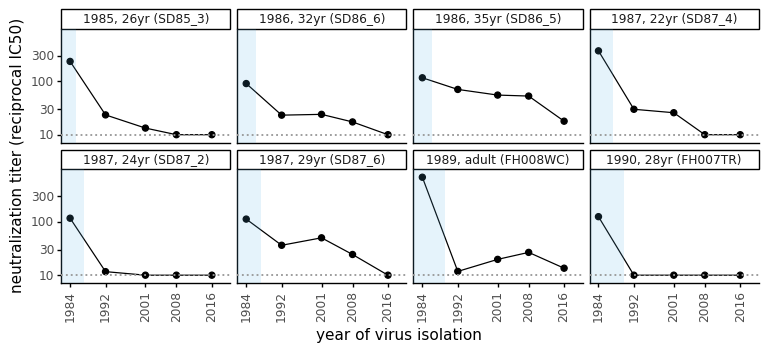


Sera with closest recent virus from 1992, full spike viruses only, saving to results/sera_1992.svg:


/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


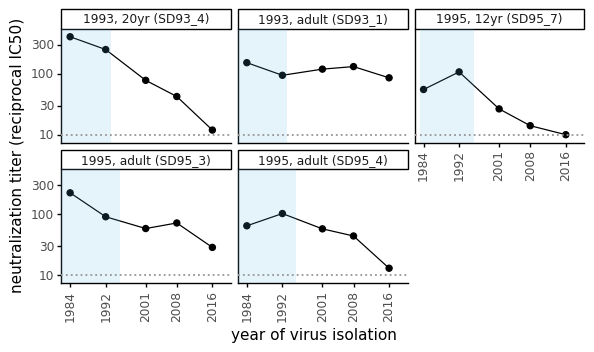


Sera with closest recent virus from 2016, full spike viruses only, saving to results/sera_2016.svg:


/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


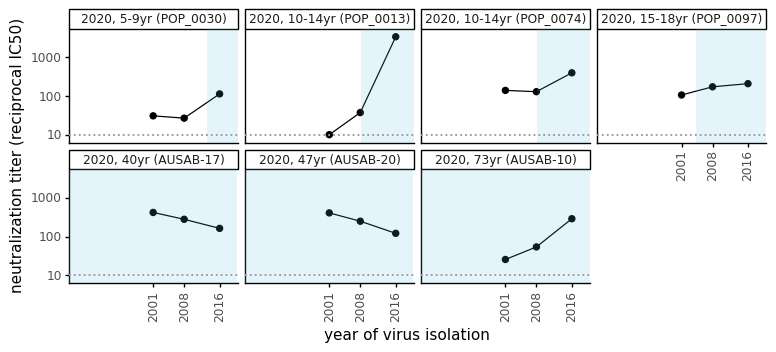


Sera with closest recent virus from 1984 including RBD chimeras, saving to results/sera_1984_rbd_chimera.svg:


/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/scales/scale_shape.py:79: PlotnineWarning: Using shapes for an ordinal variable is not advised.
/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/scales/scale_linetype.py:46: PlotnineWarning: Using linetype for an ordinal variable is not advised.
/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/scales/scale_shape.py:79: PlotnineWarning: Using shapes for an ordinal variable is not advised.
/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/plotnine/scales/scale_linetype.py:46: PlotnineWarning: Using linetype for an ordinal variable is not advised.


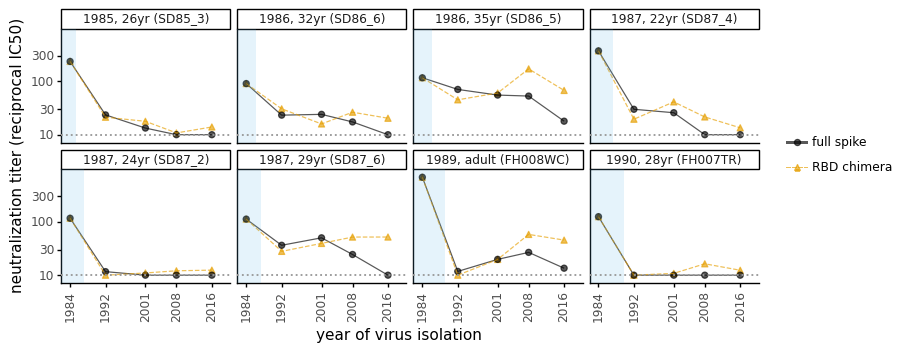

In [17]:
# map age strings to numbers used for plotting rectangles showing life span,
# and text labels for facet titles
class dict_missing_as_key(dict):
    # https://stackoverflow.com/a/6229253
    def __missing__(self, key):
        return key
age_str_to_number = dict_missing_as_key({'unknown': 40,
                                         '5 to <10 years': 7,
                                         '10 to <15 years': 12,
                                         '>15 years': 16.5,
                                          })
neut_history_df = (
      annotated_neut_titers
      .merge(closest_virus_df[['serum', 'closest_virus', 'sera_range', 'titer_to_closest_virus']],
             on=['serum', 'closest_virus'])
      .query('titer_to_closest_virus > @titer_cutoff')
      .assign(age_number=lambda x: x['age'].map(age_str_to_number).astype(int),
              birth_date=lambda x: x['collection_year'] - x['age_number'],
              )
      )
neut_history_df = neut_history_df.append(neut_history_df.query('virus == "229E-1984"')
                                         .assign(rbd_chimera=True)
                                         )
assert all(neut_history_df['birth_date'] < neut_history_df['collection_year'])

# now set x min and max (year range showed), and set geom_rect values for these for each sera
xmin = neut_history_df['virus_year'].min() - 2
xmax = max(neut_history_df['virus_year'].max() + 2, neut_history_df['collection_year'].max())
neut_history_df = neut_history_df.assign(year_min=lambda x: x['birth_date'].clip(lower=xmin),
                                         year_max=lambda x: x['collection_year'].clip(upper=xmax),
                                         )

# now set serum labels facet titles, then order by isolation year followed by patient age
class dict_missing_as_age_key(dict):
    # https://stackoverflow.com/a/6229253
    def __missing__(self, key):
        return str(key) + 'yr'
age_str_to_label = dict_missing_as_age_key({'unknown': 'adult',
                                            '5 to <10 years': '5-9yr',
                                            '10 to <15 years': '10-14yr',
                                            '>15 years': '15-18yr',
                                            })
neut_history_df = (neut_history_df
                   .assign(collection_year_round=lambda x: x['collection_year'].round().astype(int),
                           serum_label=lambda x: x['collection_year_round'].astype(str) +
                                                 ', ' + x['age'].map(age_str_to_label) +
                                                 ' (' + x['serum'] + ')'
                           )
                   .sort_values(['collection_year_round', 'age_number'])
                   .assign(serum_label=lambda x: pd.Categorical(x['serum_label'],
                                                                x['serum_label'].unique(),
                                                                ordered=True)
                           )
                   )

# nice name for `rbd_chimera` label
neut_history_df['rbd_chimera_label'] = pd.Categorical(
                                        neut_history_df['rbd_chimera'].map({True: 'RBD chimera',
                                                                            False: 'full spike'}),
                                        ['full spike', 'RBD chimera'], ordered=True)

# now define function that draws plots
def plot_neut_histories(df, ncol=4, linevar=None):
    nfacets = df['serum_label'].nunique()
    nrow = math.ceil(nfacets / ncol)
    groupvars = ['virus_year', 'serum_label']
    if linevar is not None:
        aes_kwargs = {'shape': linevar, 'linetype': linevar, 'color': linevar}
        groupvars.append(linevar)
        linealpha = 0.65
    else:
        aes_kwargs = {}
        linealpha = 1
    assert len(df) == len(df.groupby(groupvars))
    p = (
        ggplot(df) +
        aes(x='virus_year', y='neut_titer', **aes_kwargs) +
        geom_point(alpha=linealpha, size=2) +
        geom_line(alpha=linealpha) +
        facet_wrap('~ serum_label',
                   ncol=ncol,
                   nrow=nrow) +
        scale_y_log10(name='neutralization titer (reciprocal IC50)',
                      expand=(0.08, 0),
                      ) +
        scale_x_continuous(name='year of virus isolation',
                          breaks=df['virus_year'].sort_values().unique(),
                          expand=(0, 0),
                          limits=(xmin, xmax),
                          ) +
        theme_classic() +
        geom_rect(data=df[['serum_label', 'year_min', 'year_max']].drop_duplicates(),
                  mapping=aes(xmin='year_min', xmax='year_max'),
                  inherit_aes=False,
                  ymin=0, ymax=100, fill=CBPALETTE[2], alpha=0.15) +
        scale_color_manual(values=['black'] + [c for c in CBPALETTE[1:] if c not in {CBPALETTE[2]}]) +
        theme(axis_text_x=element_text(angle=90),
              figure_size=(2.25 * ncol, 1.65 * nrow),
              legend_title=element_blank(),
              ) +
        geom_hline(yintercept=titer_lower_bound, linetype='dotted', color=CBPALETTE[0], size=0.75)
        )
    return p
                   
# make plot for all sera including RBD chimera measurements
print('\nAll sera including RBD chimera viruses:')
p = plot_neut_histories(neut_history_df, linevar='rbd_chimera_label')
fig = p.draw()
display(fig)
plt.close(fig)

# plots for sera closest to 1984 and 1992 viruses (only full spike viruses)
for year, ncol in [(1984, 4),
                   (1992, 3),
                   (2016, 4),
                   ]:
    svg = f"results/sera_{year}.svg"
    print(f"\nSera with closest recent virus from {year}, full spike viruses only, saving to {svg}:")
    p = plot_neut_histories(neut_history_df.query('closest_virus_year == @year')
                                           .query('rbd_chimera == False'),
                            ncol=ncol,
                            )
    p.save(svg, verbose=False)
    fig = p.draw()
    display(fig)
    plt.close(fig)
    
# make plot for RBD chimeras for sera closest to 1984 virus
svg = 'results/sera_1984_rbd_chimera.svg'
print(f"\nSera with closest recent virus from 1984 including RBD chimeras, saving to {svg}:")
p = plot_neut_histories(neut_history_df.query('closest_virus_year == 1984'),
                        linevar='rbd_chimera_label')
p.save(svg, verbose=False)
fig = p.draw()
display(fig)
plt.close(fig)

Now plot the fold change in the neutralization titer for the next two viruses for each sera:

Summary statistics on fold changes in neutralization titer:


,n_sera,median_fold_change,geometric_mean_fold_change
n_ahead_label,,,
8-9 yrs,13,0.26,0.21
16-17 yrs,13,0.17,0.19



Plotting fold changes and saving to results/foldchange.svg


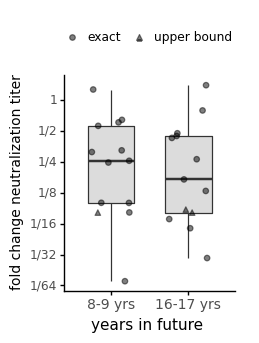

In [15]:
virus_years = sorted(neut_history_df['virus_year'].unique())

n_ahead_set = [1, 2]  # look at viruses this far ahead of initial

n_ahead_labels = {1: '8-9 yrs',
                  2: '16-17 yrs'}

next_virus_df = (
    neut_history_df
    .query('not rbd_chimera')
    [['serum', 'closest_virus_year', 'virus_year', 'titer_to_closest_virus',
      'neut_titer', 'is_upper_bound']]
    .assign(n_ahead=lambda x: x.apply(lambda r: virus_years.index(r['virus_year']) -
                                                virus_years.index(r['closest_virus_year']),
                                      axis=1),
            n_ahead_label=lambda x: pd.Categorical(x['n_ahead'].map(n_ahead_labels),
                                                   n_ahead_labels.values(), ordered=True),
            fold_change=lambda x: x['neut_titer'] / x['titer_to_closest_virus'],
            log2_fold_change=lambda x: x['fold_change'].apply(lambda t: math.log(t, 2)),
            upper_bound=lambda x: x['is_upper_bound'].map({False: 'exact',
                                                           True: 'upper bound'}),
            )
    .query('n_ahead in @n_ahead_set')
    )

print(f"Summary statistics on fold changes in neutralization titer:")
display(HTML(next_virus_df
             .groupby('n_ahead_label')
             .aggregate(n_sera=pd.NamedAgg('fold_change', 'count'),
                        median_fold_change=pd.NamedAgg('fold_change', 'median'),
                        geometric_mean_fold_change=pd.NamedAgg('fold_change',
                                                               lambda s: s.product()**(1 / len(s)))
                        )
             .to_html(float_format='%.2g')
             ))

p = (ggplot(next_virus_df) +
     aes('n_ahead_label', 'fold_change') +
     geom_boxplot(width=0.6, outlier_shape=None, outlier_alpha=0, fill='gainsboro') +
     geom_jitter(aes(shape='upper_bound'),
                 alpha=0.5, random_state=4, height=0, width=0.25, size=1.75) +
     theme_classic() +
     theme(figure_size=(1.1 * len(n_ahead_set), 2.8),
           axis_text_x=element_text(size=10),
           axis_title_y=element_text(size=10),
           legend_title=element_blank(),
           legend_position='top',
           ) +
     scale_y_log10(name='fold change neutralization titer',
                   breaks=[2, 1, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5, 2**-6],
                   labels=['2', '1', '1/2', '1/4', '1/8', '1/16', '1/32', '1/64']) +
     xlab('years in future')
     )

svg_file = 'results/foldchange.svg'
print(f"\nPlotting fold changes and saving to {svg_file}")
_ = p.draw()
p.save(svg_file, verbose=False)

Use [svgutils](https://svgutils.readthedocs.io/) to assemble a plot with the neutralization histories and fold changes, using [imagesize](https://github.com/shibukawa/imagesize_py) to get the SVG sizes:

In [16]:
neut_history_fig_svg = 'results/neut_history_fig.svg'
print(f"Creating neutralization history SVG as {neut_history_fig_svg}")

def svg_dim(svgfile, dim):
    """Get width or height `dim` of `svgfile` in points."""
    return float(ElementTree.parse(svgfile)
                            .getroot().attrib[dim]
                            .replace('px', '')
                            .replace('pt', '')
                            )

top_padding = 10
vert_padding = 20
horiz_padding = 25

svgutils.compose.Figure(
    max([svg_dim('results/sera_1984.svg', 'width'),
         svg_dim('results/sera_1992.svg', 'width') + horiz_padding +
         svg_dim('results/foldchange.svg', 'width'),
         ]
        ),
    (svg_dim('results/sera_1984.svg', 'height') + 
     svg_dim('results/sera_1992.svg', 'height') +
     top_padding + vert_padding),
    svgutils.compose.Panel(
        svgutils.compose.SVG('results/sera_1984.svg'),
        svgutils.compose.Text('A', 2, 5, size=18, font='Arial'),
        ).move(0, top_padding),
    svgutils.compose.Panel(
        svgutils.compose.SVG('results/sera_1992.svg'),
        svgutils.compose.Text('B', 2, 5, size=18, font='Arial'),
        ).move(0, svg_dim('results/sera_1984.svg', 'height') + top_padding + vert_padding),
    svgutils.compose.Panel(
        # this panel manually shifted 20 units up due to extra padding on box plot
        svgutils.compose.SVG('results/foldchange.svg'),
        svgutils.compose.Text('C', 2, 25, size=18, font='Arial'),
        ).move(svg_dim('results/sera_1992.svg', 'width') + horiz_padding,
               svg_dim('results/sera_1984.svg', 'height') + top_padding + vert_padding - 20)
    ).save(neut_history_fig_svg)

display(SVG(neut_history_fig_svg))

Creating neutralization history SVG as results/neut_history_fig.svg
